# Kálmán-szűrés 1.

## Rövid áttekintés

* Rudolf Emil Kálmán (1930-[2016](http://www.ematlap.hu/index.php/tudomany-tortenet-2016-09/347-kalman-rudolf-es-a-kalman-szuro)) magyar származású amerikai villamosmérnök, matematikus publikálja az elméletet (1960) <img src="REK.jpg" width="180">
* Első alkalmazása: ember nélküli amerikai Hold-szonda (1963)
* Navigációs és mérnöki alkalmazások
* Szenzor adatok fúziója (radar, lézerszkenner, kamera, INS,…)
* GNSS vevők, okostelefonok, számítógépek, játékok, stb. elmaradhatatlan része
* Tőzsde előrejelzés, idősor elemzés, függvény approximáció

Az eredeti [publikáció](https://www.cs.unc.edu/~welch/kalman/media/pdf/Kalman1960.pdf) közel 25 ezer hivatkozást kapott. Pillantsunk bele:
<img src="KalmanP.png" width="680">

## Meg lehet érteni?

A Kálmán-szűrés olyan algoritmus, amely valamely lineáris dinamikus rendszerben egzakt következetést tesz lehetővé, amely a rejtett Markov-modellhez hasonló Bayes-féle modell, azonban a rejtett változók állapottere folytonos, és minden rejtett és megfigyelhető változó (gyakran többváltozós) normális eloszlású.

A fenti definíció korrekt, de a legtöbbünk számára nem teszi érthetővé, hogy **valójában** mi is a Kálmán-szűrő. Ezért a megértés érdekében egyesével sorra vesszük a Kálmán-szűrő legfontosabb sajátosságait:

* rekurzív
* optimális
* közvetett (rejtett) állapotot becsül

Ezek után egy geodéziai szempontból talán könnyebben érthető módon levezetjük a Kálmán-szűrő egyenleteit és egy egyszerű navigációs példán keresztül mutatjuk be a Kálmán-szűrő működését.

## Rekurzív becslés

A legegyszerűbb példa az, amikor valamely egyetlen $x$ változóval jellemezhető rendszer állapotát mérjük egymás utáni $t_1, t_2, ... , t_n$ időpontokban. 

A méréseink legyenek $x_1, x_2, ... , x_n$.

Az állapot legjobb becslése ez esetben (Gauss-eloszlást feltételezve) a jól ismert számtani közép vagy *átlag*:

$$ \mu_n = \frac{1}{n} \sum_{i=1}^n x_i.$$

Tegyük fel, hogy van egy új mérésünk, $x_{n+1}$, és a célunk az állapot becslése ezen új mérés felhasználásával. Ez az $n+1$ mérésből számított átlag lesz:

$$ \mu_{n+1} = \frac{1}{n+1} \sum_{i=1}^{n+1} x_i.$$

Viszont sokkal hatékonyabb az az eljárás, amikor felhasználjuk a már kiszámított $\mu_n$ átlagot és csak ezt "frissítjük" az új mérés felhasználásával:

$$ \mu_{n+1} = \frac{n}{n+1} \left( \frac{1}{n} \sum_{i=1}^n x_i +  \frac{1}{n} x_{n+1} \right) = \frac{n}{n+1}\mu_n +  \frac{1}{n+1} x_{n+1}.$$

Igazából így működik a zsebszámológépünk `STAT` funkciója is: az egymás után bevitt adatok segítségével folyamatosan "frissíti" az átlag értékét. Ez a *rekurzív becslés* lényege: a már meglévő becslést az újabb adatok beérkezése után mindig módosítjuk, "aktualizáljuk". Példánkban a rekurzív állapot becslés így írható fel kicsit más alakban:

$$\mu_{n+1} = \frac{n}{n+1}\mu_n +  \frac{1}{n+1} x_{n+1} = \mu_n + K(x_{n+1} - \mu_n),$$

ahol 

$$K = \frac{1}{n+1}$$

az ún. *erősítés*, amelyik megmondja, hogy mekkora lesz a régi átlag, azaz a $\mu_n$ korrekciója, illetve

$$x_{n+1} - \mu_n,$$

amelyik az *új információ* (idegen szóval: *innováció*), hiszen ettől függ, hogy egyáltalán változik-e az előző becslés. Ugyanis ha az új $x_{n+1}$ mérés megegyezik a régi $\mu_n$ átlaggal, a becslésünk egyáltalán nem fog változni.

Nézzük meg mindezt az alábbi számpéldán keresztül:

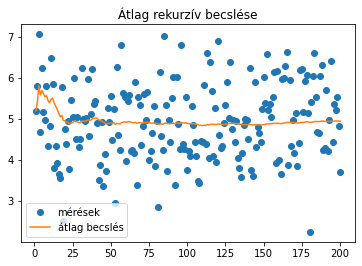

In [1]:
import numpy as np
import matplotlib.pyplot as plt

""" Kálmán-szűrő: rekurzív átlag becslés
"""

npt = 200
x = 5 + np.random.randn(npt)
n = np.arange(1,npt+1)
K = 1.0/(n+1)
mu = np.zeros((npt))
mu[0] = x[0]

for i in range(1,npt):
    mu[i] = mu[i-1] + K[i]*(x[i]-mu[i-1])

plt.plot(n,x,'o',label='mérések')
plt.plot(n,mu,label='átlag becslés')
plt.legend()
plt.title('Átlag rekurzív becslése')
plt.show()

A példa jól bemutatta a Kálmán-szűrő egyik nagyon fontos jellemzőjét: **rekurzív becslést** szolgáltat a mérések függvényében a rendszer állapotára.

Most vegyük szemügyre a Kálmán-szűrés másik fontos sajátosságát: a szűrő a különböző információkat *optimális* módon hasznosítja a becslés során.

## Különböző információk optimális felhasználása

Tegyük fel, hogy $x$-et *két különböző eszközzel* mérjük (pl. ha $x$ távolság, akkor megmérjük mérőszalaggal és kézi lézer távmérővel is). Legyen az első eszközzel végzett mérés eredménye $x_1$, a másiké pedig $x_2$. A két mérőeszköz nem azonos pontossággal dolgozik. Ezt a tényt a méréseik különböző $\sigma_1$ illetve $\sigma_2$ szórásaival (középhibáival) fejezhetjük ki.

Célunk az, hogy *optimális* becslést adjunk $x$-re a két $x_1$, $x_2$ mérés és $\sigma_1$,  $\sigma_2$ szórásaik segítségével. Legyen ez a becslés a két mérés *súlyozott átlaga*:

$$\hat{x} = wx_1 + (1-w)x_2.$$

A kérdés tehát az, hogy milyen $w$ súly esetén lesz az $\hat{x}$ becslés $\hat\sigma$ szórása minimális?

Mivel feltételezzük azt, hogy mind $x_1$, mind $x_2$ *Gauss-eloszlású*, ezért a valószínűségszámítás [nevezetes eredménye](https://www.statlect.com/probability-distributions/normal-distribution-linear-combinations) szerint a lineáris kombinációjuk is normális eloszlású lesz, amelynek a szórása

$$\hat\sigma^2 = w^2\sigma_1^2 + (1-w)^2 \sigma_2^2.$$

Az optimális $w_{opt}$ súly ennek a kifejezésnek a minimuma lesz, vagyis ahol a $w$ szerinti derivált zérus:

$$\frac{\partial \hat\sigma^2}{\partial w} = 2w_{opt}\sigma_1^2-2(1-w_{opt})\sigma_2^2 = 0.$$

Az optimális súly tehát

$$ w_{opt} = \frac{\sigma_2^2}{\sigma_1^2+\sigma_2^2}.$$

Ezek után megadhatjuk $x$ optimális $\hat{x}$ becslését:

$$ \hat{x} = \frac{\sigma_2^2}{\sigma_1^2+\sigma_2^2} x_1 + \frac{\sigma_1^2}{\sigma_1^2+\sigma_2^2} x_2.$$

Az optimális becslés szórását is kiszámíthatjuk az alábbi összefüggéssel:

$$ \hat\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}.$$

Számunkra, földmérők számára egyébként ez a jól ismert súlyozott legkisebb négyzetes becslés, hiszen $\hat{x}$ minimalizálja a javítások súlyozott négyzetösszegét:

$$\hat{x} =  \underset{x}{\arg \min} = \left[ p_1 (x_1 - x)^2 + p_2 (x_2 - x)^2 \right],$$

ahol $p_1$, $p_2$ a súlyok, melyek arányosak a szórásnégyzetek reciprokaival. Valóban, a fenti kifejezést $x$ szerint deriválva és a deriváltat zérussal egyenlővé téve a 

$$ p_1(x_1-\hat{x}) + p_2(x_2-\hat{x}) = 0$$

egyenletet kapjuk, melynek megoldása $\hat{x}$-re

$$ \hat{x} = \frac{1}{p_1+p_2}(p_1 x_1 + p_2 x_2)$$

lesz, ami megegyezik a korábbi megoldással, ha $p_1=1/\sigma_1^2$ és  $p_2=1/\sigma_2^2$.

## Rekurzív optimális becslés

Az előző optimális becslést fogalmazzuk át úgy, hogy rendelkezzünk először az $x_1$ méréssel, és ezt "frissítsük" az új $x_2$ mérés beérkezése után egy korrekcióval. Nyilván az első lépésben $\hat{x_1} = x_1$, $\hat\sigma_1^2=\sigma_1^2$, ahol az alsó index a lépésre utal. A második lépésben frissítsük a becslést

$$\hat{x}_2 = \hat{x}_1 + \frac{\hat{\sigma}_1^2}{\hat{\sigma}_1^2 + \sigma_2^2} (x_2 - \hat{x}_1),$$

$$\hat{\sigma}_2^2 = \left( 1 - \frac{\hat{\sigma}_1^2}{\hat{\sigma}_1^2 + \sigma_2^2}  \right) \hat{\sigma}_1^2.$$

A zárójelben található $(x_2 - \hat{x}_1)$ tényező az *új információ* (innováció), az előtte található szorzótényező, 

$$\frac{\hat{\sigma}_1^2}{\hat{\sigma}_1^2 + \sigma_2^2}$$

pedig a $K$ *erősítési tényező*. Foglaljuk most össze a rekurzív optimális becslésre vonatkozó egyenleteinket:

$$\hat{x}_2 = \hat{x}_1 + K(x_2 - \hat{x}_1),$$

$$\hat{\sigma}_2^2 = ( 1 - K ) \hat{\sigma}_1^2,$$

$$K = \frac{\hat{\sigma}_1^2}{\hat{\sigma}_1^2 + \sigma_2^2}.$$

Láthatjuk, hogy ez alakjára nézve teljesen hasonlít a korábbi rekurzív becslésre, amely így nézett ki

$$\mu_{n+1} = \mu_n + K(x_{n+1} - \mu_n),$$

csak most sikerült megtalálni a $K$ erősítési tényező *optimális* értékét annak érdekében, hogy a becslés hibája (szórása) a lehető legkisebb legyen. Ezt az optimális becslést folyamatosan elő tudjuk állítani mindig amikor egy új mérés érkezik.

Már most megjegyezzük, hogy amikor az állapotot nem egyetlen $x$ változóval, hanem több változóból álló  $\mathbf{x} = (x_1, x_2, ...)$ vektorral írhatjuk le, akkor is hasonló az eljárás, csak ez esetben varianciák helyett kovariancia mátrixokkal fogunk dolgozni. Ez többek között azt vonja majd maga után, hogy reciprok képzés helyett inverz képzésre lesz szükség.

## Közvetett állapot becslés

Idáig feltételeztük azt, hogy a rendszer $x$ állapota *közvetlenül* mérhető. A gyakorlatban sokszor erre nincs lehetőségünk, csak arra, hogy a rendszer állapotától függő valamilyen $\mathbf{z}$ mennyiségeket megmérjünk. A geodéziában ezt a helyzetet igen jól ismerjük: ez a közvetett mérések feldolgozásának (II. kiegyenlítési csoport) esete. Ezt a feladatot oldja meg a Kálmán-szűrő is: a közvetlenül nem mérhető (vagyis "rejtett") rendszer állapotot szeretnénk becsülni a méréseink alapján. 

Először a *statikus* rendszerekkel foglalkozunk, vagyis olyanokkal, amelyekben a rendszer állapota időben nem változik. De mind a statikus, mind a dinamikus (időben változó állapotú) rendszerek esetében feltételezünk egy nagyon fontos dolgot: a rendszer $\mathbf{x}$ állapota **lineáris** modellen keresztül kapcsolódik a mérhető $\mathbf{z}$ mennyiségekhez:

$$ \mathbf{z} = \mathbf{H} \mathbf{x} + \mathbf{r}.$$

Ebben az összefüggésben a $\mathbf{H}$ mátrix a mérési modell (számunkra ez a jól ismert alakmátrix), továbbá $\mathbf{r}$ a zérus átlagú ($\bar{\mathbf{r}}=\mathbf{0}$) és Gauss-eloszlású mérési hibákat (mérési zajt) jellemzi. Ezeket a hibákat (zajt) az $\mathbf{R}$ *zaj kovariancia mátrix* írja le

$$ \mathbf{R} = \mathbb{E}\left[ (\mathbf{r} - \bar{\mathbf{r}}) (\mathbf{r} - \bar{\mathbf{r}})^T  \right]$$

ahol $\mathbb{E}[.]$ a várható értéket jelöli. Célunk optimális $\hat{\mathbf{x}}$ becslést adni a rendszer állapotára, amely minimalizálja a kovariancia mátrix inverzével súlyozott mérési zajt (mérési hibákat). Ez az igen jól ismert paraméteres kiegyenlítés (a paraméterek vektora most a rendszer $\mathbf{x}$ állapota), ahol a $\mathbf{P}$ súlymátrix arányos a zaj kovariancia mátrix $\mathbf{R}^{-1}$ inverzével.

<u>**Rekurzív becslés**</u>

A hagyományos paraméteres kiegyenlítéssel szemben most tételezzük fel azt, hogy a mérések folyamatosan (nem egyszerre) érkeznek. Minden egyes $k$ mérési időpontban érkezik egy új $\mathbf{z}_k$ mérés és szeretnénk a rendszer $\hat{\mathbf{x}}_k$ állapotára, illetve a rendszer állapot $\hat{\mathbf{P}}_k$ kovariancia mátrixára optimális  becslést adni  Ezt a minimalizációs feladatot kell tehát megoldani:

$$\hat{\mathbf{x}}_k =  \underset{x}{\arg \min} = \left[ (\mathbf{z}_k-\mathbf{H}_k \mathbf{x})^T \mathbf{R}_k^{-1} (\mathbf{z}_k-\mathbf{H}_k \mathbf{x}) \right].$$

Ennek a minimalizációs feladatnak a megoldása a *statikus Kálmán-szűrő*. A szűrő kiszámítja az új $\hat{\mathbf{x}}_k$ becslést és annak $\hat{\mathbf{P}}_k$ kovariancia mátrixát az előző $\hat{\mathbf{x}}_{k-1}$, $\hat{\mathbf{P}}_{k-1}$ becslésekből és a $\mathbf{z}_k$ mérésből valamint annak $\mathbf{R}_k$ kovariancia mátrixából. 

Megemlítjük, hogy tipikus példa a statikus Kálmán-szűrésre a fix helyzetű GNSS vevő méréseinek a feldolgozása. Ez esetben a rejtett állapot ($\mathbf{x}$ paraméter vektor) a vevő ismeretlen koordinátája és a vevő órájának igazítatlansága. A $\mathbf{z}$ mérések pedig a műhold-vevő áltávolságok. Ha az összes mérés egyszerre rendelkezésre áll, akkor ez a hagyományos legkisebb négyzetes kiegyenlítéssel megoldható. Amennyiben a mérések epochánként folyamatosan érkeznek, akkor rekurzív kiegyenlítésre, vagyis statikus Kálmán-szűrésre van szükség.

A következőkben levezetjük a statikus Kálmán-szűrő egyenleteit a geodéziában ismert *csoportokban történő kiegyenlítés* segítségével. Látni fogjuk, hogy a statikus Kálmán szűrő összefüggései igazából teljesen megegyeznek a közvetítő egyenletekkel törénő kiegyenlítés során alkalmazott folyamatos csoportképzés egyenleteivel.


## Statikus Kálmán-szűrő egyenletei

A levezetésben követni fogjuk Detrekői: Kiegyenlítő számítások tankönyvének 5.8.2-es pontjában alkalmazott gondolatmenenetet. A jelöléseket viszont a Kálmán-szűrő esetében szokásos jelöléshez közelítjük, így könnyebben látjuk majd a kapcsolatot a két eljárás között. Csak a lineáris esetre korlátozódunk, tehát nincs szükség a közvetítő egyenleteknek a paraméterek előzetes értékei helyén végzett linearizációjára.

A folyamatos csoportképzés esetében a méréseket különböző időben végezzük, s a később végzett mérések kiegyenlítésekor felhasználjuk a korábban végzett mérések eredményeit is. Abból indulunk ki, hogy az $i=1$ alkalommal a $\mathbf{z}_1$ mérési eredmények ($n$ db.) alapján meghatároztuk a kiegyenlített $\mathbf{x}_1$ paramétereket és azok $\mathbf{P}_{11}$ kovariancia mátrixát a mérések $\mathbf{R}_{11}$ kovariancia mátrixát felhasználva, a 

$$ \mathbf{r}_1 = \mathbf{z}_1 - \mathbf{H}_1\mathbf{x}_1 $$

lineáris javítási (reziduál) egyenletekből kiindulva az

$$ \mathbf{N}_1 \mathbf{x}_1 - \mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1 = \mathbf{0}$$

normálegyenletek alapján. Ha az $ \mathbf{N}_1= \mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{H}_1$ normálegyenlet együtthatómátrixa nem szinguláris, akkor az ismeretlen paraméterek értéke

$$\mathbf{x}_1 = \mathbf{N}_1^{-1}\mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1 .$$

A kiegyenlített paraméterek kovariancia mátrixa

$$ \mathbf{P}_{11} = \mathbf{N}_1^{-1} =  (\mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{H}_1)^{-1}.$$

A kiegyenlítés elvégzése után az $i+1=2$ alkalommal további ($s$ db.) mérést végzünk, ezek eredménye $\mathbf{z}_2$, kovariancia mátrixa $\mathbf{R}_{22}$. Tételezzük fel, hogy ezek a mérések függetlenek a korábbi mérésektől. Határozzuk meg az új $\mathbf{x}_2$ paramétervektort, a javítások (reziduálok) új $\mathbf{r}_r$ vektorát és a kiegyenlített paraméterek új $\mathbf{P}_{22}$ kovariancia mátrixát.

Az együttes feldolgozáskor a normálegyenlet

$$ (\mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{H}_1 + \mathbf{H}_2^T\mathbf{R}_{22}^{-1}\mathbf{H}_2)\mathbf{x}_2 - ( \mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1 + \mathbf{H}_2^T\mathbf{R}_{22}^{-1}\mathbf{z}_2) = \mathbf{0}.$$

A megoldás érdekében vezessük be az új  $\mathbf{y}$ ($s$ méretű) paramétert:

$$ \mathbf{y}= \mathbf{R}_{22}^{-1}\mathbf{r}_2 = \mathbf{R}_{22}^{-1}\mathbf{z}_2 -\mathbf{R}_{22}^{-1}\mathbf{H}_2  \mathbf{x}_2 .$$

Ekkor az  $\mathbf{y}$ segítségével a

$$ \mathbf{r}_2 = \mathbf{z}_2 - \mathbf{H}_2\mathbf{x}_2 $$

javítási (reziduál) egyenlet átalakítható csak paramétereket tartalmazó kényszerfeltételi egyenletté:

$$ \mathbf{R}_{22}\mathbf{y}= \mathbf{z}_2 - \mathbf{H}_2\mathbf{x}_2,$$

amiből a szokásos felépítésű kényszerfeltételi egyenlethez jutunk:

$$ \mathbf{z}_2 - \mathbf{H}_2\mathbf{x}_2 - \mathbf{R}_{22}\mathbf{y} = \mathbf{0}$$

A bevezetett $\mathbf{y}$ vektort felhasználva a normálegyenlet átalakítható:

$$(\mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{H}_1)\mathbf{x}_2 - \mathbf{H}_2^T\mathbf{y} -  \mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1 = \mathbf{0}$$

A kényszerfeltételi egyenleteket hozzávéve ehhez az átalakított normálegyenlethez a következő $n+s$ méretű blokkos egyenletrendszerhez jutunk:

$$\begin{bmatrix} \mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{H}_1 & - \mathbf{H}_2^T \\ - \mathbf{H}_2 & - \mathbf{R}_{22}\end{bmatrix}  \begin{bmatrix} \mathbf{x}_2\\ \mathbf{y}\end{bmatrix} = \begin{bmatrix} \mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1\\ -\mathbf{z}_2\end{bmatrix}. $$

Az $\mathbf{x}_2$-re vonatkozó megoldás meghatározása érdekében invertáljuk az egyenletrendszer $\mathbf{A}$ blokkos együttható mátrixát. Ehhez a Gauss-Jordan kiküszöbölést fogjuk alkalmazni. Az inverz meghatározása során kiindulunk a kibővített

$$\begin{bmatrix} \mathbf{A} & | &  \mathbf{I} \end{bmatrix} $$

mátrixból és a Gauss-Jordan eliminációval ebből kihozzuk a

$$\begin{bmatrix} \mathbf{I} & | &  \mathbf{A}^{-1} \end{bmatrix} $$

alakot ($\mathbf{I}$ az egységmátrixot jelöli).

A kiinduló kibővített mátrix (az egyszerűsítés érdekében $\mathbf{N}=\mathbf{N}_1$)

$$\begin{bmatrix} \mathbf{N} & - \mathbf{H}_2^T & \mathbf{I} & \mathbf{0}  \\ - \mathbf{H}_2 & - \mathbf{R}_{22} & \mathbf{0} & \mathbf{I}\end{bmatrix} $$

első sorát szorozzuk végig balról $\mathbf{N}^{-1}$-el, majd adjuk hozzá a második sorhoz az $\mathbf{H}_2$-vel balról szorzott első sort. Mivel $\mathbf{H}_2\mathbf{I}=\mathbf{H}_2$, ha az $\mathbf{I}$ $r\times r$ méretű egységmátrix, eredményül a

$$\begin{bmatrix} \mathbf{I} & - \mathbf{N}^{-1}\mathbf{H}_2^T & \mathbf{N}^{-1} & \mathbf{0}  \\ \mathbf{0} & - \mathbf{R}_{22}- \mathbf{H}_2\mathbf{N}^{-1}\mathbf{H}_2^T & \mathbf{H}_2\mathbf{N}^{-1} & \mathbf{I}\end{bmatrix} $$

kibővített mátrixot kapjuk. Vezessük be az $\mathbf{S} = (\mathbf{R}_{22}+ \mathbf{H}_2\mathbf{N}^{-1}\mathbf{H}_2^T)^{-1}$ jelölést. Balról a második sort $-\mathbf{S}$-el végigszorozva a

$$\begin{bmatrix} \mathbf{I} & - \mathbf{N}^{-1}\mathbf{H}_2^T & \mathbf{N}^{-1} & \mathbf{0}  \\ \mathbf{0} & \mathbf{I} & -\mathbf{S}\mathbf{H}_2\mathbf{N}^{-1} & -\mathbf{S}\end{bmatrix} $$

mátrixot kapjuk meg. Végül adjuk hozzá az első sorhoz a balról $\mathbf{N}^{-1}\mathbf{H}_2^T$-vel szorzott második sort. Eredményül a

$$\begin{bmatrix} \mathbf{I} & \mathbf{0} & \mathbf{N}^{-1} - \mathbf{N}^{-1}\mathbf{H}_2^T\mathbf{S}\mathbf{H}_2\mathbf{N}^{-1} & -\mathbf{N}^{-1}\mathbf{H}_2^T\mathbf{S}  \\ \mathbf{0} & \mathbf{I} & -\mathbf{S}\mathbf{H}_2\mathbf{N}^{-1} & -\mathbf{S}\end{bmatrix} $$

kibővített mátrixot kapjuk, amelynek jobb oldalán a keresett inverz mátrix áll.


Ezzel az inverz mátrixszal balról végigszorozva a megoldandó egyenletrendszert megkapjuk a keresett megoldást

$$\begin{bmatrix} \mathbf{x}_2\\ \mathbf{y}\end{bmatrix} =  \begin{bmatrix} \mathbf{N}^{-1} - \mathbf{N}^{-1}\mathbf{H}_2^T\mathbf{S}\mathbf{H}_2\mathbf{N}^{-1} & -\mathbf{N}^{-1}\mathbf{H}_2^T\mathbf{S}  \\ -\mathbf{S}\mathbf{H}_2\mathbf{N}^{-1} & -\mathbf{S}\end{bmatrix} \begin{bmatrix} \mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1\\ -\mathbf{z}_2\end{bmatrix}. $$

Ha a továbbiakban a $\mathbf{K} =\mathbf{N}^{-1}\mathbf{H}_2^T\mathbf{S} $ jelölést alkalmazzuk, akkor az $\mathbf{x}_2$-re vonatkozó megoldás

$$ \mathbf{x}_2 = \mathbf{N}^{-1}\mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1 - \mathbf{K}\mathbf{H}_2\mathbf{N}^{-1}\mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1 + \mathbf{K}\mathbf{z}_2.$$

Ezt egyszerűsíteni tudjuk, ha figyelembe vesszük, hogy $\mathbf{x}_1 = \mathbf{N}_1^{-1}\mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1 $. Végeredményben

$$ \mathbf{x}_2 = \mathbf{x}_1 - \mathbf{K}\mathbf{H}_2\mathbf{x}_1 + \mathbf{K}\mathbf{z}_2 = \mathbf{x}_1 + \mathbf{K}(\mathbf{z}_2 - \mathbf{H}_2\mathbf{x}_1  ).$$


Az $\mathbf{S}$ mátrixot visszaírva (mivel $\mathbf{N}^{-1}=\mathbf{P}_{11}$)

$$ \mathbf{K} = \mathbf{P}_{11}\mathbf{H}_2^T(\mathbf{R}_{22} + \mathbf{H}_2 \mathbf{P}_{11} \mathbf{H}_2^T)^{-1}.$$

A kiegyenlített paraméterek kovariancia mátrixa pedig az invertált hipermátrix bal felső blokkja (vagyis az $\mathbf{x}_2$-höz tartozó blokk)

$$ \mathbf{P}_{22} = (\mathbf{I} - \mathbf{K}\mathbf{H}_2) \mathbf{P}_{11}.$$

Ezek megegyeznek a statikus Kálmán-szűrő egyenleteivel. A $\mathbf{K}$ a Kálmán-féle erősítési mátrix, $\mathbf{H}$ a mérési mátrix, $\mathbf{x}$ pedig a rendszer állapota. A szűrő minden új mérés után frissíti a rendszer állapot becslését és az állapot becslésének $ \mathbf{P}$ kovariancia mátrixát.

A *dinamikus* Kálmán-szűrő egyenletei mindössze annyiban térnek el ettől, hogy a rendszer $ \mathbf{x}$ állapota is változik:

$$\mathbf{x}_{k+1} = \mathbf{F}\mathbf{x}_k + \mathbf{B}\mathbf{u}_k + \mathbf{q}$$

a $k$-adik időpontról a $k+1$-edik időpontra, ahol $\mathbf{F}$ az állapot átmenet mátrixa, $\mathbf{u}$ a rendszer gerjesztése, $\mathbf{B}$ a gerjesztés (vezérlés) mátrixa és $\mathbf{q}$ a zérus átlagú rendszer zaj, aminek $\mathbf{Q}$ a kovariancia mátrixa.

A dinamikus rendszer állapot-átmenete utáni $\mathbf{P}^-$ kovariancia mátrixot egyszerűen a jól ismert kovariancia terjedéssel (hibaterjedés) számíthatjuk ki:

$$\mathbf{P}^-_k = \mathbf{H} \mathbf{P}_{k-1} \mathbf{H}^T + \mathbf{Q}.$$

Érdemes megjegyezni, hogy a Kálmán-szűrő egyenleteit valószínűségszámítási megfontolások alapján közvetlenül is le lehet vezetni (lásd [Pradu](https://math.stackexchange.com/questions/840662/an-explanation-of-the-kalman-filter) válaszát)

## Példa a Kálmán-szűrésre: járműnavigáció

Példaként vegyünk egy egyenes úton haladó járművet. A modellünkben a rendszer (jármű) $x$
állapotát a $p$ helyzete és $v$ sebessége jellemzi. Az $u$ bemenetet az általunk alkalmazott ismert gyorsulások jelentik és az $y$ kimenet a mért helyzetinformációval azonosítható. Mondjuk azt, hogy gyorsulásokkal vezéreljük a rendszert és a helyzetét $T$ másodperces időközönként mérjük. Ez esetben az elemi kinematikai ismereteink szerint a $v$ sebesség a következő egyenlettel írható le:

$$v_{k+1} = v_k + Tu_k.$$

Viszont ez a modell még nem teljes. Ugyanis a sebesség véletlenszerűen is megváltozhat elkerülhetetlen külső tényezők miatt. A sebesség $\tilde{v}_k$ zaja időfüggő valószínűségi változó, ezért 

$$v_{k+1} = v_k + Tu_k + \tilde{v}_k$$

a sebességre vonatkozó modellünk. Ehhez hasonló egyenletet írhatunk fel a $p$ helyzetre:

$$p_{k+1} = p_k + Tv_k + \frac{1}{2}T^2u_k + \tilde{p}_k,$$

ahol $\tilde{p}_k$ a helyzet bizonytalansága (zaja). Az állapotvektor mint említettük a helyzetből és a sebességből áll:

$$x_k = \left[ p_k \atop v_k \right].$$

Mivel tudjuk, hogy a mért $z$ mennyiség a jármű helyzete, az alábbi lineáris rendszeregyenleteket írhatjuk fel:

$$x_{k+1} = \begin{bmatrix}1 & T\\0 & 1 \end{bmatrix} x_k + \begin{bmatrix}T^2/2\\T \end{bmatrix} u_k + w_k$$

$$y_k =\begin{bmatrix}1 & 0\end{bmatrix} x_k + \nu_k.$$

A mérés $\nu_k$ zaja a mérőeszköz hibájából adódik. Célunk pedig a jármű $x$ állapotának minél pontosabb megismerése.

A Kálmán-szűrés esetében viszonylag könnyű a mérési zaj, esetünkben a jármű pozíciója hibájának ($R$ "mátrix", mely egyetlen elemből álló skalár) a meghatározása, mivel a felhasznált mérőeszköz pontosságát általában ismerjük. Legye a példánkban a helyzet meghatározás szórása ± 3 méter. Nehezebb feladat a rendszer zaj $Q$ kovariancia mátrixának felvétele. Erre az ún. diszkrét fehérzaj gyorsulás modellt (DWNA) alkalmazzuk. Ha ismerjük a gyorsulás $w_{acc}$ mérési zaját (legyen ez a példánkban ± 0.2 m/$\mathrm{s}^2$) akkor a rendszer zaj kovariancia mátrixa

$$Q = \begin{bmatrix}¼T^4 & ½T^3\\½T^3 & T^2 \end{bmatrix} w_{acc}^2.$$

A jármű helyzetének és sebességének becslését a `kalman(duration,dt)` függvény végzi el Kálmán-szűréssel, és a jármű pontos, mért valamint becsült helyzetét egy ábrán szemléltetjük a szimuláció lefutása után. Az ábráról jól látszik, hogy miért is nevezhető ez az eljárás szűrésnek.

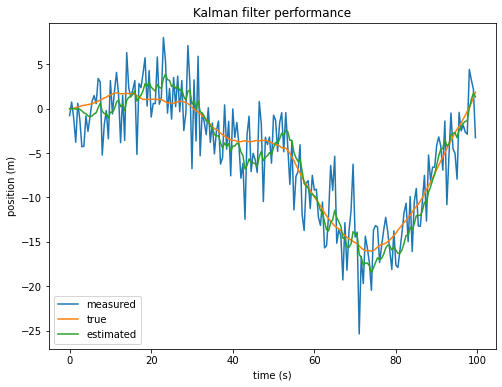

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def kalman(duration, dt, accelnoise = 0.2):
    ## function kalman(duration, dt) - Kalman filter simulation
    ## duration = length of simulation (seconds)
    ## accelnoise = acceleration noise (m/sec**2)
    ## dt = step size (seconds)

    measnoise  = 3     ## position measurement noise (m)

    F = np.array([[1, dt],[0, 1]])  ## state transition matrix
    H = np.array([[1, 0]])            ## measurement matrix
    x = np.array([[0, 0]]).T    ## initial state vector
    xhat = x     ## initial state estimate

    Q = accelnoise**2 * np.array([[dt**4/4, dt**3/2],[dt**3/2, dt**2]])    ## process noise covariance
    P = Q     ## initial estimation covariance
    R = measnoise**2     ## measurement error covariance

    dimt = int(duration/dt)      ## number of epochs
    pos     = np.zeros(dimt)     ## true position array
    poshat  = np.zeros(dimt)     ## estimated position array
    posmeas = np.zeros(dimt)     ## measured position array

    k = 0
    for t in np.arange(0,duration,dt):    
        ## Simulate process
        ProcessNoise = accelnoise * np.array([[(dt**2/2)*np.random.normal(), dt*np.random.normal()]]).T
        x = np.dot(F,x) + ProcessNoise
        ## Simulate measurement z at epoch t
        MeasNoise = measnoise * np.random.normal()    
        z = np.dot(H,x) + MeasNoise    
        ## Innovation: z - H.xh
        Inn = z - np.dot(H,xhat)    
        ## Covariance of Innovation: S = H.P.H' + R
        S = np.dot(np.dot(H,P),H.T) + R    
        ## Gain matrix K = F.P.H'.inv(S)
        K = np.dot(np.dot(np.dot(F,P),H.T),np.linalg.inv(S))
        ## State estimate: xh = F.xh + K.Inn 
        xhat = np.dot(F,xhat) + np.dot(K,Inn)    
        ## Covariance of prediction error: P = F.P.F' + Q - K.H.P.F'
        P = np.dot(np.dot(F,P),F.T) + Q - np.dot(np.dot(np.dot(K,H),P),F.T)    
        ## Save some parameters in vectors for plotting later
        pos[k]     = x[0]    
        posmeas[k] = z    
        poshat[k]  = xhat[0]
        k = k + 1

    return pos,posmeas,poshat   

## Simulate

duration = 100
dt = 0.5
p,pm,phat = kalman(duration,dt)

## Plot the results
t = np.arange(0,duration,dt)
plt.figure(figsize=(8,6))
plt.plot(t,pm,label='measured')
plt.plot(t,p,label='true')
plt.plot(t,phat,label='estimated')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.title('Kalman filter performance')
plt.show()    

Ez az egyszerű példa jól bemutatta a Kálmán-szűrés alapvető algoritmusát. A gyakorlatban azonban általában a mérések függése az állapottól nem lineáris, vagyis nem írható le egyszerűen egy $\mathbf{H}$ mérési mátrixszal. Ezzel az esettel a továbbiakban foglalkozunk, ami el fog vezetni a kibővített Kálmán-szűrés (Extended Kalman Filter, EKF) és a szagtalan Kálmán-szűrés (Unscented Kalman Filter, UKF) eseteihez.